# Проверка параметрических гипотез

# Библиотеки

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.diagnostic import kstest_normal
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.proportion import binom_test
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.proportion import binom_test, proportions_ztest, proportions_chisquare
from statsmodels.distributions.empirical_distribution import ECDF

import math

# Warmup

## Стандартный Z-test

Линия по производству пудры должна обеспечивать средний вес пудры в
упаковке 4 грамма, заявленное стандартное отклонение — 1 грамм.
В ходе инспекции выбрано 9 упаковок, средний вес продукта в них составляет
4.6 грамма.

$H_0$: средний вес пудры в упаковке соответствует норме.

$H_1$: средний вес пудры в упаковке не соответствует норме.

```p=0.0719```

Проверим критерий "вручную":

$Z = \frac{\bar{X}-\mu}{\sigma/\sqrt{n}}.$

$p(Z) = 2 \bigl(1-F(|Z|)\bigr).$

In [2]:
mu = 4
std = 1
n = 9
mean = 4.6

In [3]:
Z = (mean - mu) / (std / (n**(0.5)))
Z

1.799999999999999

In [4]:
st.distributions.norm(0, 1).cdf(Z)

0.9640696808870741

In [5]:
p = 2*(1 - st.distributions.norm(0, 1).cdf(Z))
p

0.07186063822585176

Просэмплируем похожую выборку и проверим критерий с использованием библиотеки ```statsmodels```

In [6]:
#np.random.seed(42)

X = np.random.randn(n) * std + mean
print('mean={}, std={}'.format(np.mean(X), np.std(X)))

mean=4.46811929216787, std=0.7413955710723107


In [7]:
print('Z={}, p={}'.format(*ztest(X, value=mu)))

Z=1.785877007155, p=0.07411917459910668


In [8]:
print('Z={}, p={}'.format(*ztest(X, value=mu, alternative = 'larger')))

Z=1.785877007155, p=0.03705958729955334


# Разрушители легенд: тыльная сторона руки

## Часть 1
В 5 серии 13 сезона передачи “Разрушители легенд” проверялась справедливость выражения “know something like the back of one’s hand”. В эксперименте принимало участие 12 испытуемых. Каждому из них были предъявлены 10 фотографий похожих рук разных людей, среди которых они должны были угадать свою.

11 из 12 испытуемых выбрали свою фотографию.

$H_0$: испытуемые выбирают фотографии тыльной стороны руки наугад (p=0.1).

$H_1$: испытуемые выбирают фотографию тыльной стороны своей собственной руки осознанно (p>0.1).



In [10]:
n  = 12
T  = 11
p0 = 0.1


### Точный биномиальный критерий:

![alt text](data/binom_test.png "Title")

In [18]:
binom_test(T, n, p0, 'larger')

1.0900000000000006e-10

### Z-test

http://datalearning.ru/index.php/textbook?cid=1&mid=3&topic=3

In [19]:
proportions_ztest(T, n, p0)

(10.235766170195031, 1.371056109091178e-24)

### Доверительный интервал Уилсона

http://medstatistic.ru/articles/doveritelnye-intervaly-dlya-chastot-i-doley.pdf

In [20]:
proportion_confint(T, n, method='wilson')

(0.646120088858883, 0.9851349055950829)

### Часть 2
Аналогичный эксперимент был проведён с фотографиями ладоней. 7 из 12 испытуемых угадали свою фотографию.

$H_0$: испытуемые выбирают фотографии ладони наугад (p=0.1).

$H_1$: испытуемые выбирают фотографию своей собственной ладони осознанно (p>0.1).

In [21]:
n  = 12
T2  = 7
p0 = 0.1



In [22]:
binom_test(T2, n, p0, 'larger')

5.0180338000000016e-05

Можно ли утверждать, что тыльную сторону руки люди знают лучше, чем ладонь? Сравним результаты экспериментов.
Поскольку это одни и те же испытуемые, выборки связные. 

Но информации о связности нет, поэтому мы вынуждены использовать критерии для независимых выборок. Z-критерий:

![alt text](data/z-prop_test.png "Title")

In [25]:
P = (T + T2) / (2 * n)
Z = (T/n - T2/n)/np.sqrt(P * (1-P) *2 /n)
p_val = 1 - st.distributions.norm.cdf(Z)
p_val

0.029673219395960015

ожидаемый ответ: ```~0.03```

# Rats
**Weindruch R., Walford R.L. The Retardation of Aging and Disease by Dietary Restriction. Springfield: Charles C. Thomas, 1988.**

In [26]:
rats = pd.read_csv('data/rats.txt', delimiter='\t')
rats.head()

,lifespan,diet
0,105,restricted
1,193,restricted
2,211,restricted
3,236,restricted
4,302,restricted


In [27]:
x1 = rats.loc[rats['diet'] == 'restricted']['lifespan'].values
x2 = rats.loc[rats['diet'] == 'ad libitum']['lifespan'].values

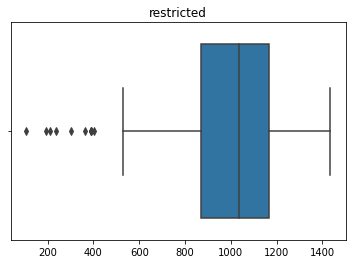

In [28]:
plt.title('restricted')
sns.boxplot(x=x1)
plt.show()

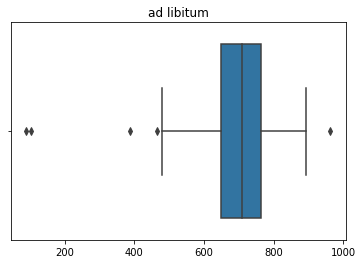

In [29]:
plt.title('ad libitum')
sns.boxplot(x=x2)
plt.show()

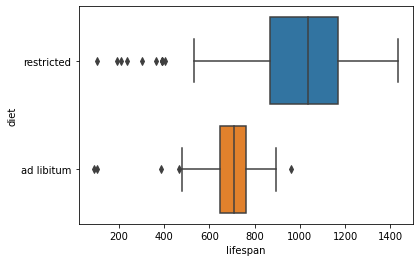

In [30]:
sns.boxplot(x='lifespan', y='diet', data=rats)
plt.show()

## Гистограммы распределений

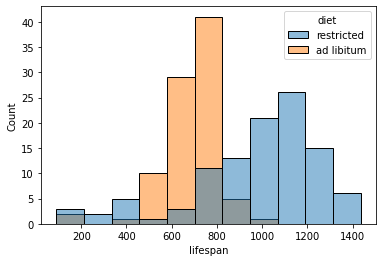

In [41]:
sns.histplot(data=rats, x = 'lifespan', hue = 'diet');

## Проверка нормальности
$H_0$: каждая из выборок нормальна

$H_1$: нет

### Shapiro

In [43]:
st.shapiro(x1), st.shapiro(x2)

(ShapiroResult(statistic=0.9036345481872559, pvalue=1.1565858812900842e-06),
 ShapiroResult(statistic=0.8444006443023682, pvalue=3.081509092339729e-08))

### q-q plot

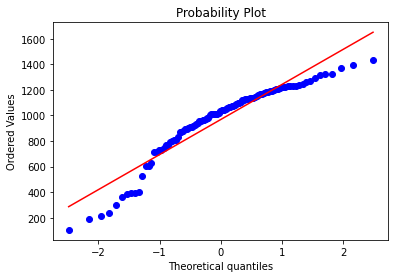

In [46]:
st.probplot(x1, plot = plt);

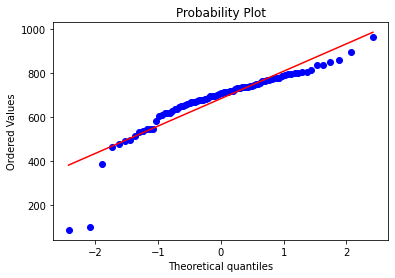

In [47]:
st.probplot(x2, plot = plt);

Попробуем исключить крыс, проживших меньше 400 дней (например, можно предположить, что смерть раньше этого срока вызывается причинами, не связанными с диетой).

In [48]:
x1c = x1[np.where(x1>=400)[0]]
x2c = x2[np.where(x2>=400)[0]]

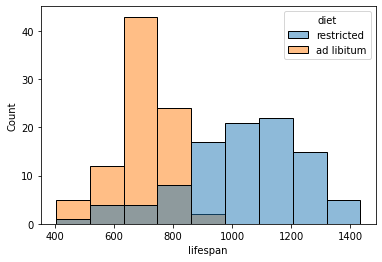

In [50]:
sns.histplot(data=rats[rats['lifespan'] >= 400], x = 'lifespan', hue = 'diet');

### Shapiro

In [52]:
st.shapiro(x1c), st.shapiro(x2c)

(ShapiroResult(statistic=0.9738006591796875, pvalue=0.04921640083193779),
 ShapiroResult(statistic=0.9765744209289551, pvalue=0.11983636021614075))

Ожидаемые p-value:
```0.049,  0.119```

Усечённые выборки можно считать практически нормальными.

## Сравнение средних

http://statistica.ru/theory/t-kriterii/

$H_0$: продолжительность жизни крыс не меняется при ограничении диеты.

$H_1$: крысы на строгой диете живут дольше.



### Усеченные выборки

In [53]:
ttest_ind(x1c, x2c, alternative='larger', usevar='unequal')

(14.527701019046814, 3.941182274101304e-30, 141.33154919379604)

In [54]:
ttest_ind(x1c,x2c, alternative='two-sided', usevar='unequal')

(14.527701019046814, 7.882364548202608e-30, 141.33154919379604)

### Полные выборки:

In [55]:
ttest_ind(x1,x2, alternative='larger', usevar='unequal')

(9.161061040974156, 1.4580405594293205e-16, 154.9404956691433)

In [56]:
ttest_ind(x1,x2, alternative='two-sided', usevar='unequal')

(9.161061040974156, 2.916081118858641e-16, 154.9404956691433)

### Задача 221
$$H_0:\mu_1=\mu_2$$
$$H_1:\mu_1 \neq \mu_2$$

$$Z = \frac{\hat{x_1} - \hat{x_2}}{\sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2}}} $$

In [106]:
x1_hat = 70.2
n1 = 4
x2_hat = 70.5
n2 = 9
sigma1 = 0.5
sigma2 = 1

In [107]:
Z = (x1_hat - x2_hat) / ((pow(sigma1, 2) / n1 + pow(sigma2, 2) / n2)**(0.5))
Z

-0.7199999999999932

In [108]:
p = 2*(1 - st.distributions.norm(0, 1).cdf(abs(Z)))
p

0.4715249955585066

In [166]:
while True:
    samp1 = st.distributions.norm(x1_hat, sigma1).rvs(n1)
    if np.isclose(samp1.mean(), x1_hat, atol = 1e-3) and np.isclose(sigma1, samp1.std(ddof = 1), atol = 1e-3):
        break
while True:
    samp2 = st.distributions.norm(x2_hat, sigma2).rvs(n2)
    if np.isclose(samp2.mean(), x2_hat, atol = 1e-3) and np.isclose(sigma2, samp2.std(ddof = 1), atol = 1e-3):
        break

KeyboardInterrupt: 

In [ ]:
samp1.mean(), samp1.std(), samp2.mean(), samp2.std()

In [ ]:
ztest(x1 = samp1, 
      x2 = samp2,
      value = 0)

In [154]:
from statsmodels.stats.weightstats import _zstat_generic as generic_ztest

In [160]:
generic_ztest(x1_hat, x2_hat, alternative="two-sided", diff = 0,  
              std_diff = math.sqrt(pow(sigma1, 2) / (n1) + pow(sigma2, 2) / (n2)))

(-0.7199999999999932, 0.4715249955585066)

### Критерий Вальда

Рассмотрим гамма распределение $$f(x; \alpha, \beta) = \frac{\beta^\alpha x^{\alpha - 1}}{e^{\beta x}\Gamma(\alpha)}$$

In [6]:
from scipy.stats import gamma, norm

In [8]:
samples_count = 1000
iters_count = 10000

h0_a = 2
h0_scale = 0.5
h0_samples = gamma.rvs(a = h0_a, scale = h0_scale, size = (iters_count, samples_count))

h1_a = 2
h1_scale = 1
h1_samples = gamma.rvs(a = h1_a, scale = h1_scale, size = (iters_count, samples_count))

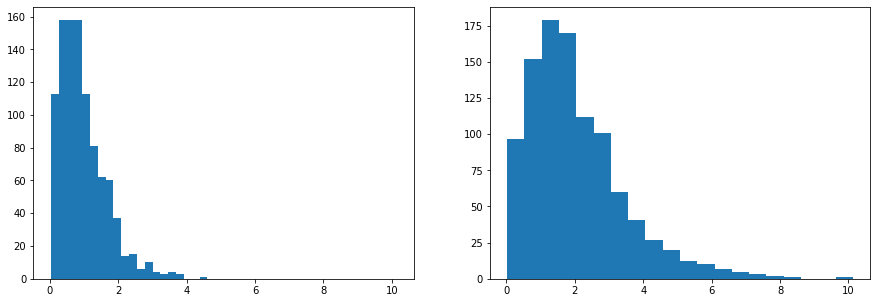

In [11]:
f, ax = plt.subplots(1,2, figsize = (15, 5), sharex = True)
ax[0].hist(h0_samples[0], bins = 20)
ax[1].hist(h1_samples[0], bins = 20)
plt.show()

Гипотеза

$$H_0:\alpha\theta=E[X]=1$$ 
$$H_1:E[X]\neq1$$ 

Рассматриваем статистику Вальда:

$$T(X) = \frac{\sum_{i=1}^{n}X_i-n\mu}{\sqrt{ns^2}}$$

где $$\mu - предполагаемое\spaceмат\spaceожидание = 1 $$

In [12]:
def calc_wald_statistics(X, samples_count, assumed_mean):
    X = np.array(X)[:samples_count]
    n = len(X)
    return (X.sum() - n * assumed_mean) / np.sqrt(n * X.var(ddof=1))

def calc_wald_statistics_multirow(X, samples_count, assumed_mean):
    X = np.array(X)[:, :samples_count]
    n = X.shape[1]
    return (X.sum(axis = 1) - n * assumed_mean) / np.sqrt(n * X.var(ddof=1, axis = 1))


При $H_0$ статистика Вальда стремится к N(0,1). Тест строится следующим образом:
Если $|T(X)|>u_{1-\alpha/2}$, то гипотеза отвергается. Проведем тест с уровнем значимости $\alpha = 0.05$

In [13]:
alpha = 0.05
norm_threshold = norm.ppf(1 - 0.5 * alpha)

Однако статистика Вальда имеет не нормальное распределение, а лишь стремится к нему. Поэтому заявленный уровень значимости (0.05) будет отличаться от истинного. Попробуем оценить истинный уровень значимости.

In [27]:
h0_stat_values = calc_wald_statistics_multirow(h0_samples, 1000, h0_a * h0_scale)
np.sum(np.abs(h0_stat_values) > norm_threshold) / iters_count

0.0513

Посмотрим на истинный уровень значимости при различных n

In [16]:
import tqdm

significance_level = []
estimated_true_thresholds = []

for n in tqdm.tqdm_notebook(range(10, 1000+1, 10)):
    h0_stat_values = calc_wald_statistics_multirow(h0_samples, n, h0_a * h0_scale)
    significance_level.append(np.sum(np.abs(h0_stat_values) > norm_threshold) / iters_count)
    estimated_true_thresholds.append(np.percentile(np.abs(h0_stat_values), (1 - alpha) * 100))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100 [00:00<?, ?it/s]

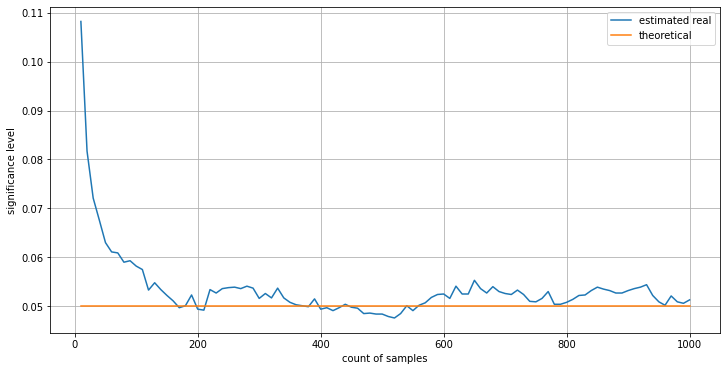

In [23]:
plt.figure(figsize = (12,6))
plt.xlabel("count of samples")
plt.ylabel("significance level")
plt.plot(range(10, 1000+1, 10), significance_level, label = 'estimated real')
plt.plot(range(10, 1000+1, 10), [alpha for i in range(10, 1000+1, 10)], label = 'theoretical')
plt.grid()
plt.legend()
plt.show()

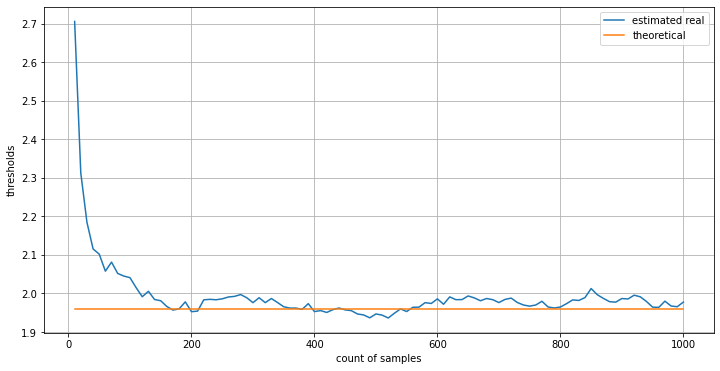

In [26]:
plt.figure(figsize = (12,6))
plt.xlabel("count of samples")
plt.ylabel("thresholds")
plt.plot(range(10, 1000+1, 10), estimated_true_thresholds, label = 'estimated real')
plt.plot(range(10, 1000+1, 10), [norm_threshold for i in range(10, 1000+1, 10)], label = 'theoretical')
plt.grid()
plt.legend()
plt.show()